In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso, ElasticNet, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

## function

In [17]:
def nanfill(data,row, column):
    tag = data.iloc[row,1]
    # print(data[data.iloc[:,1] == tag].iloc[:,column],'\n')
    temp = data[data.iloc[:,1] == tag].iloc[:,column]
    temp = np.average(temp[temp.notna()])
    if (pd.isna(temp)):
        print(row,column)
    data.iloc[row,column] = temp

def normalization(data):
    for i in range(data.shape[1]):
        m1 = min(data.iloc[:,i])
        m2 = max(data.iloc[:,i])
        data = (data.iloc[:,i] - m1) / (m2 - m1)

# 计算交叉验证结果的均值和标准差， 默认为五折交叉验证，结果为相关系数R2      
def cross_validate(models, cv = 5, scoring = 'r2'):
    means = []
    stds = []
    best_score = 0
    best_index = 0
    
    for index, model in enumerate(models):
        score = cross_val_score(model, X_train, y_train, cv = cv, scoring = scoring)
        means.append(score.mean())
        stds.append(score.std(ddof = 1))
        
        # get the best alpha and score
        curr_score = score.mean()
        if curr_score > best_score:
            best_score = curr_score
            best_index = index
    return means, stds, best_index


def plot_errbar(list_, means, stds):
    plt.errorbar(list_, means, yerr=stds, c='#06d6a0')
    plt.xlabel('Alpha')
    plt.ylabel('Accuracy')
    plt.show()

## Data import

In [43]:
raw_data = pd.read_csv('Data.csv')

for i in range(3):
    for j in range(raw_data.shape[0]):
        raw_data.iloc[j,i+2] = np.float64(raw_data.iloc[j,i+2].replace(',',''))
        
for i in range(raw_data.shape[0]):
    for j in range(raw_data.shape[1]):
        if (pd.isna(raw_data.iloc[i,j])):
            nanfill(raw_data,i,j)

## Analysis of Correlation

In [44]:
group = [['LACCESS_POP15','LACCESS_LOWI15','LACCESS_HHNV15','LACCESS_CHILD15','LACCESS_SENIORS15'],
        ['GROCPTH16', 'SUPERCPTH16', 'CONVSPTH16', 'SPECSPTH16', 'WICSPTH16'],
        ['FFRPTH16', 'FSRPTH16'],
        ['FOODINSEC_15_17', 'VLFOODSEC_15_17'],
        ['FMRKT_WIC18', 'FMRKT_WICCASH18'],
        ['POVRATE15', 'CHILDPOVRATE15']]

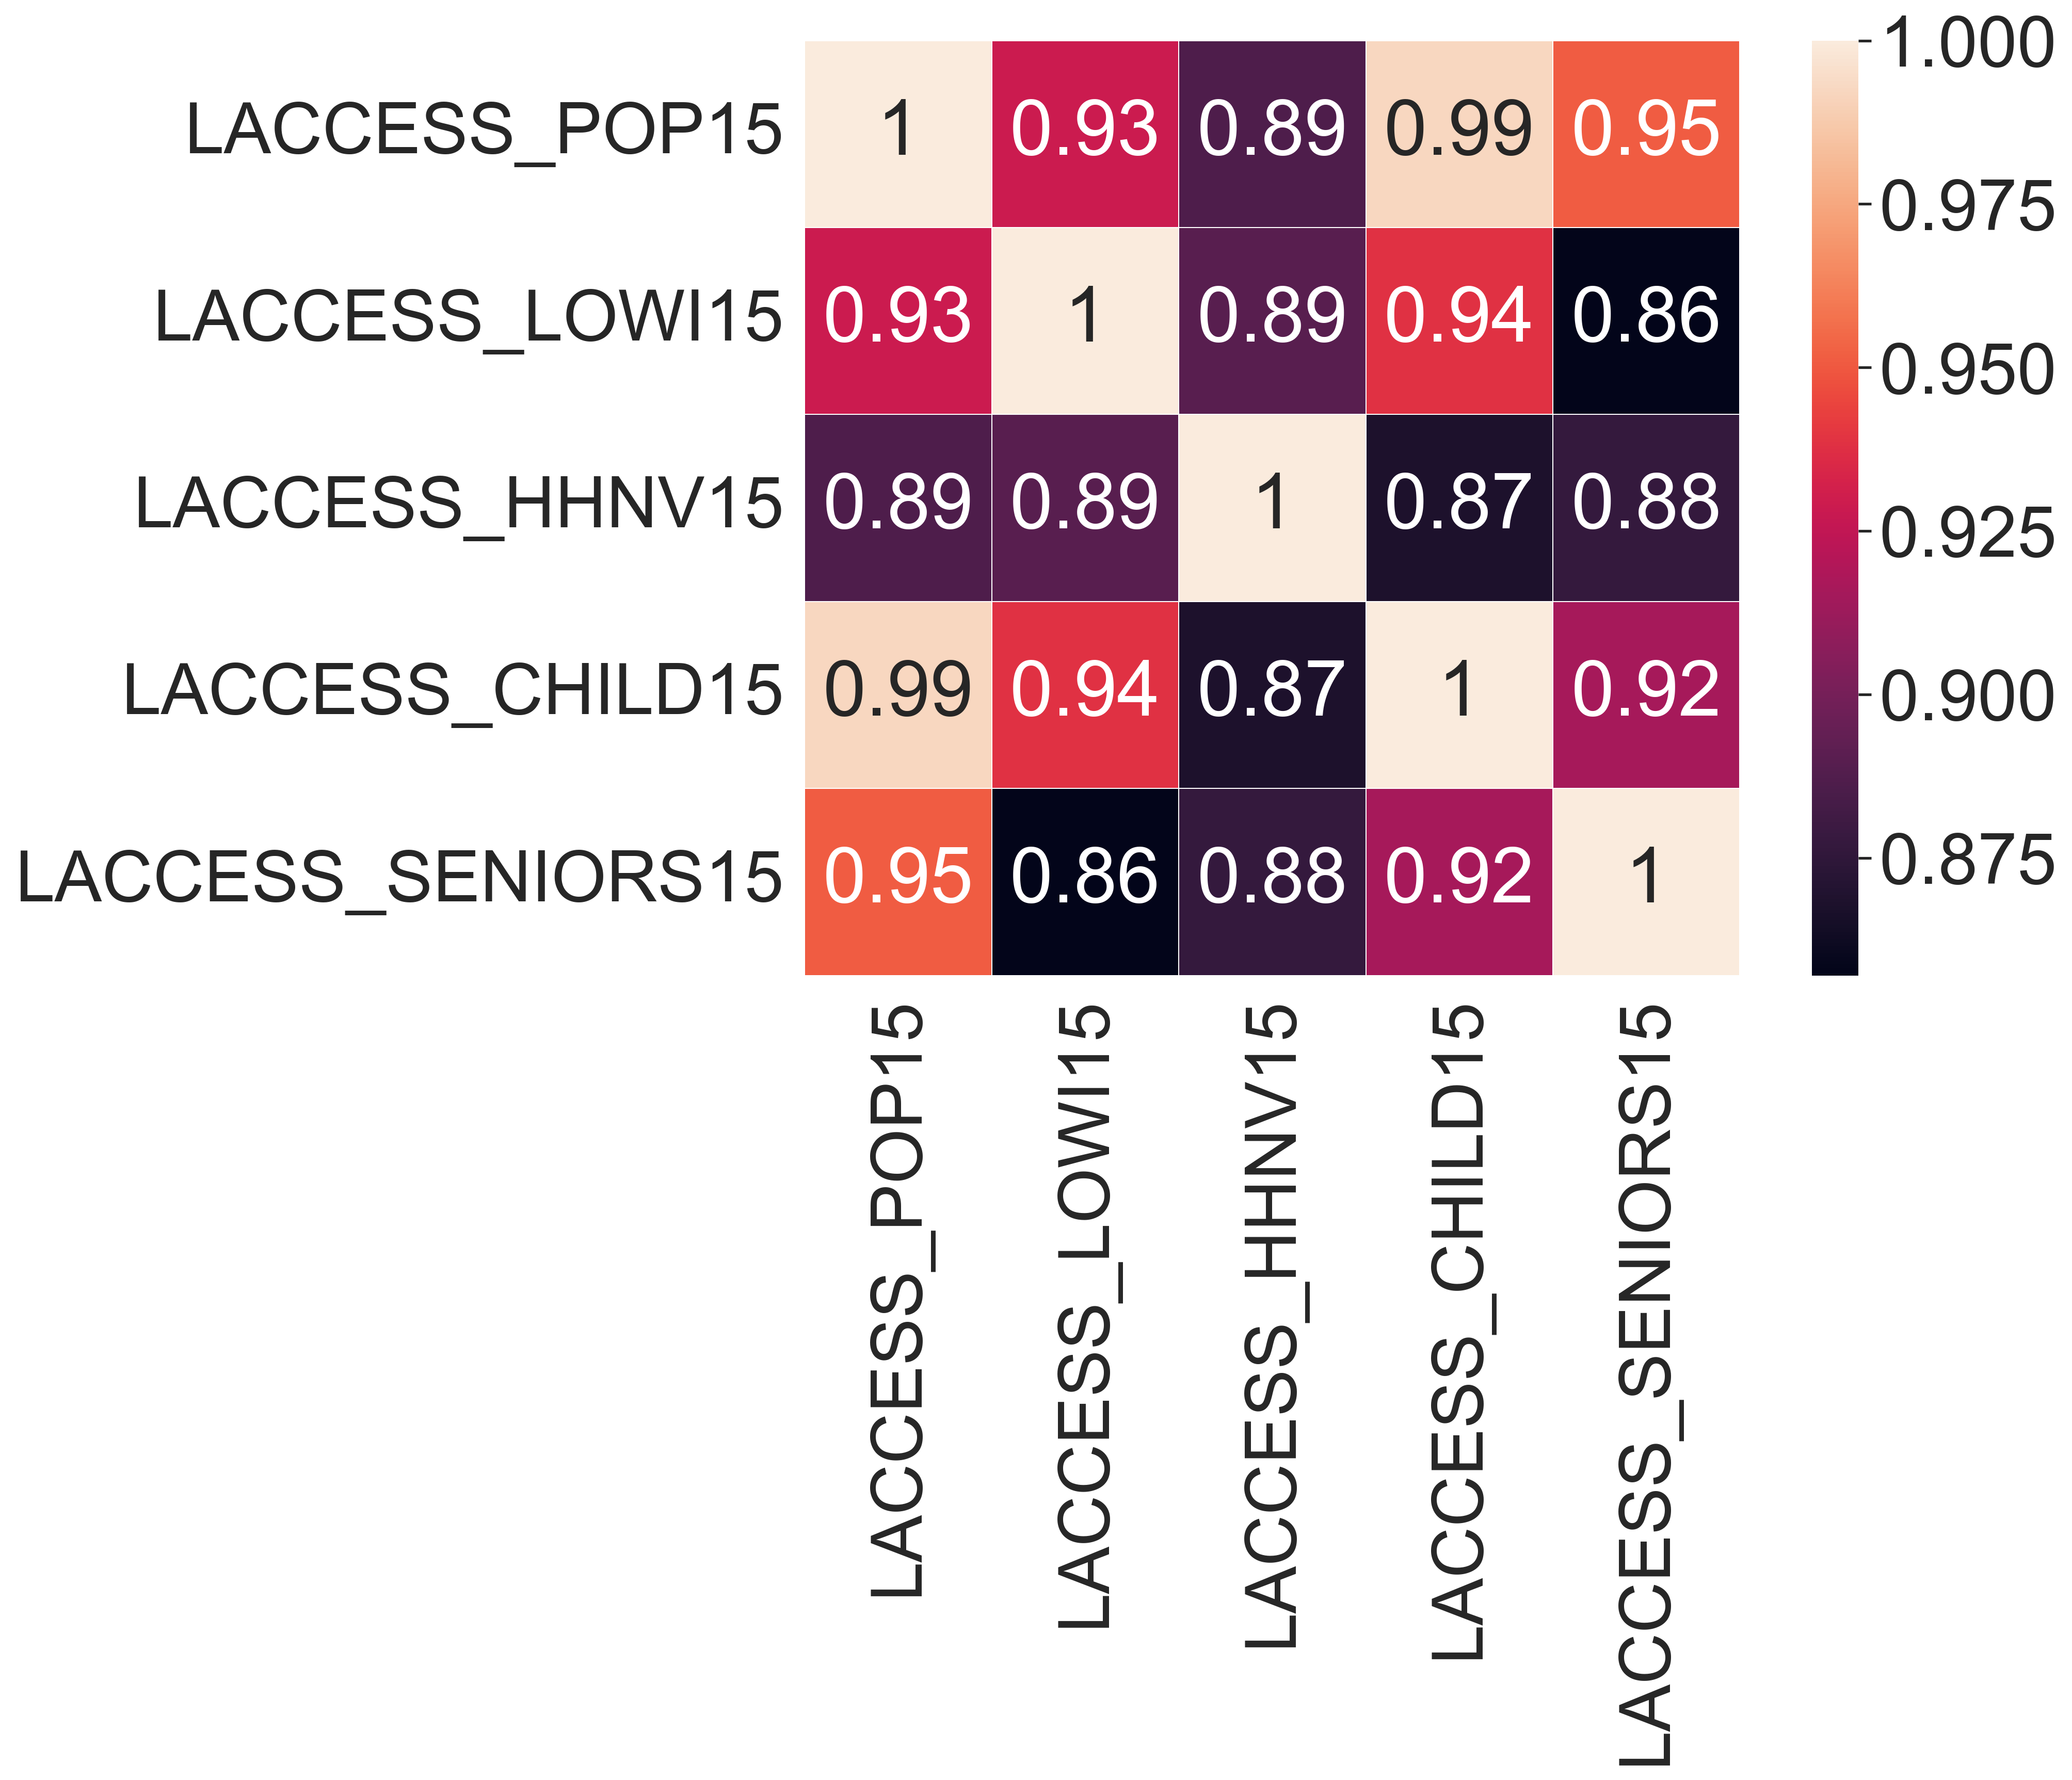

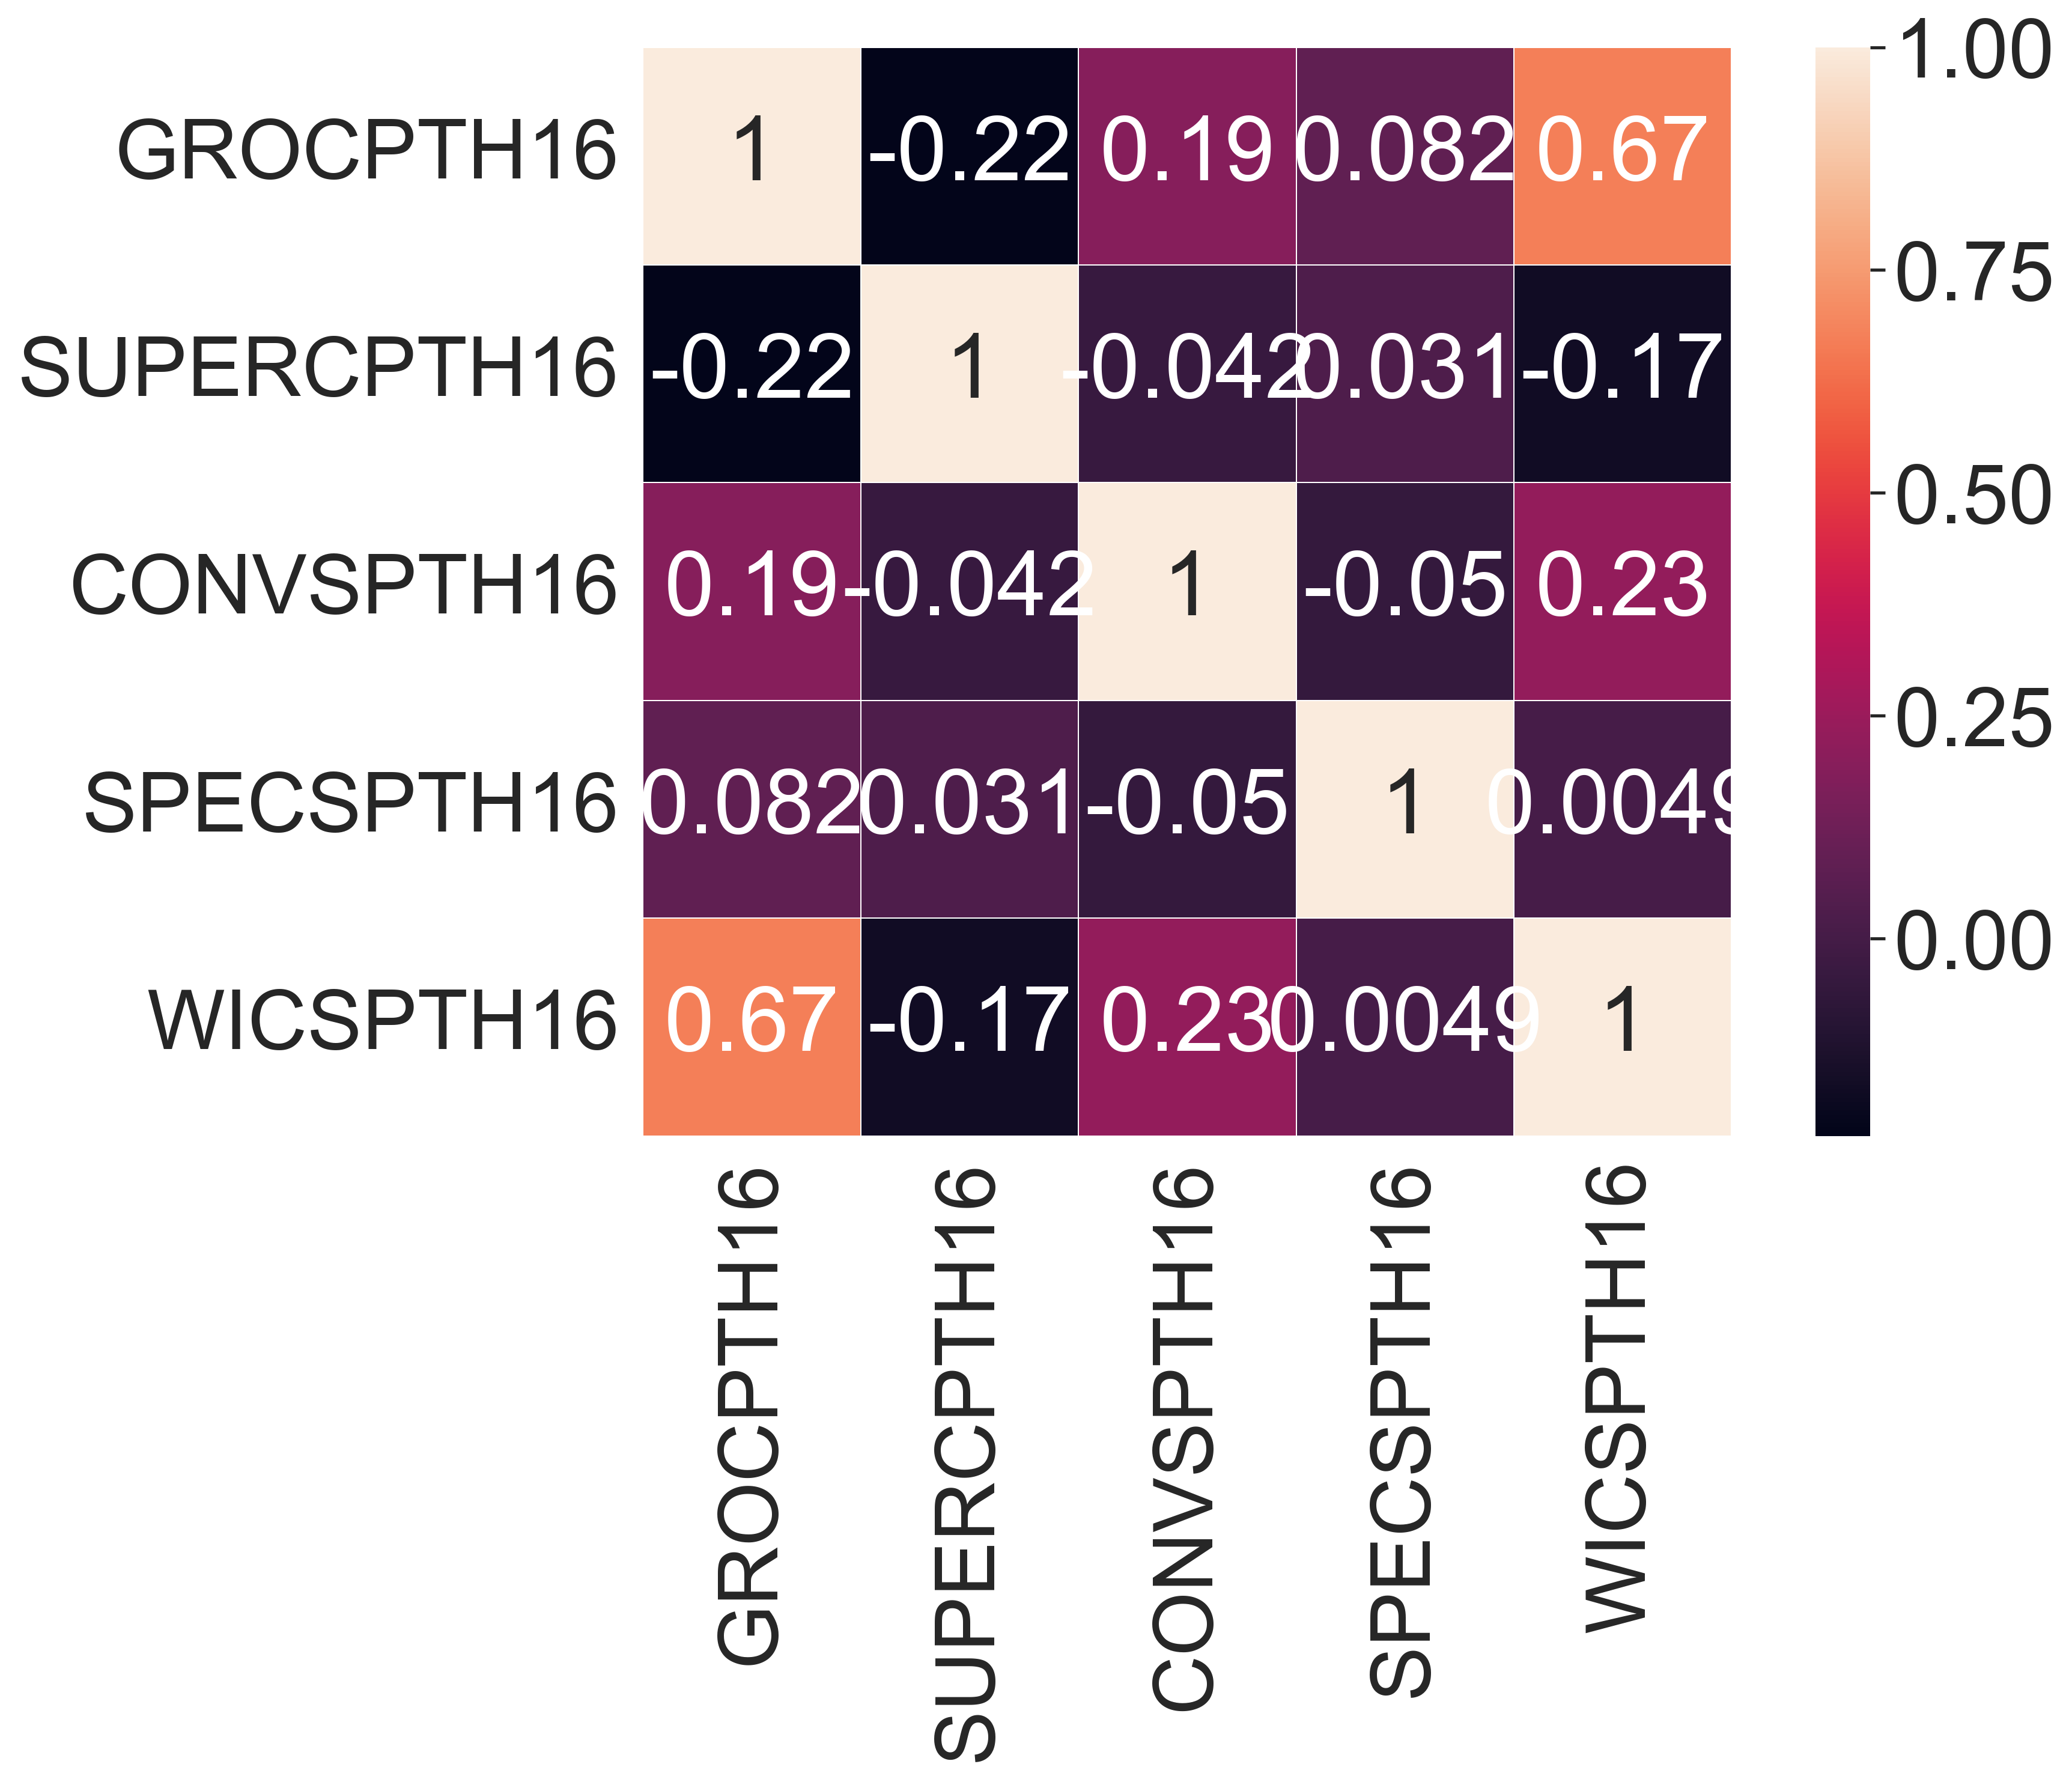

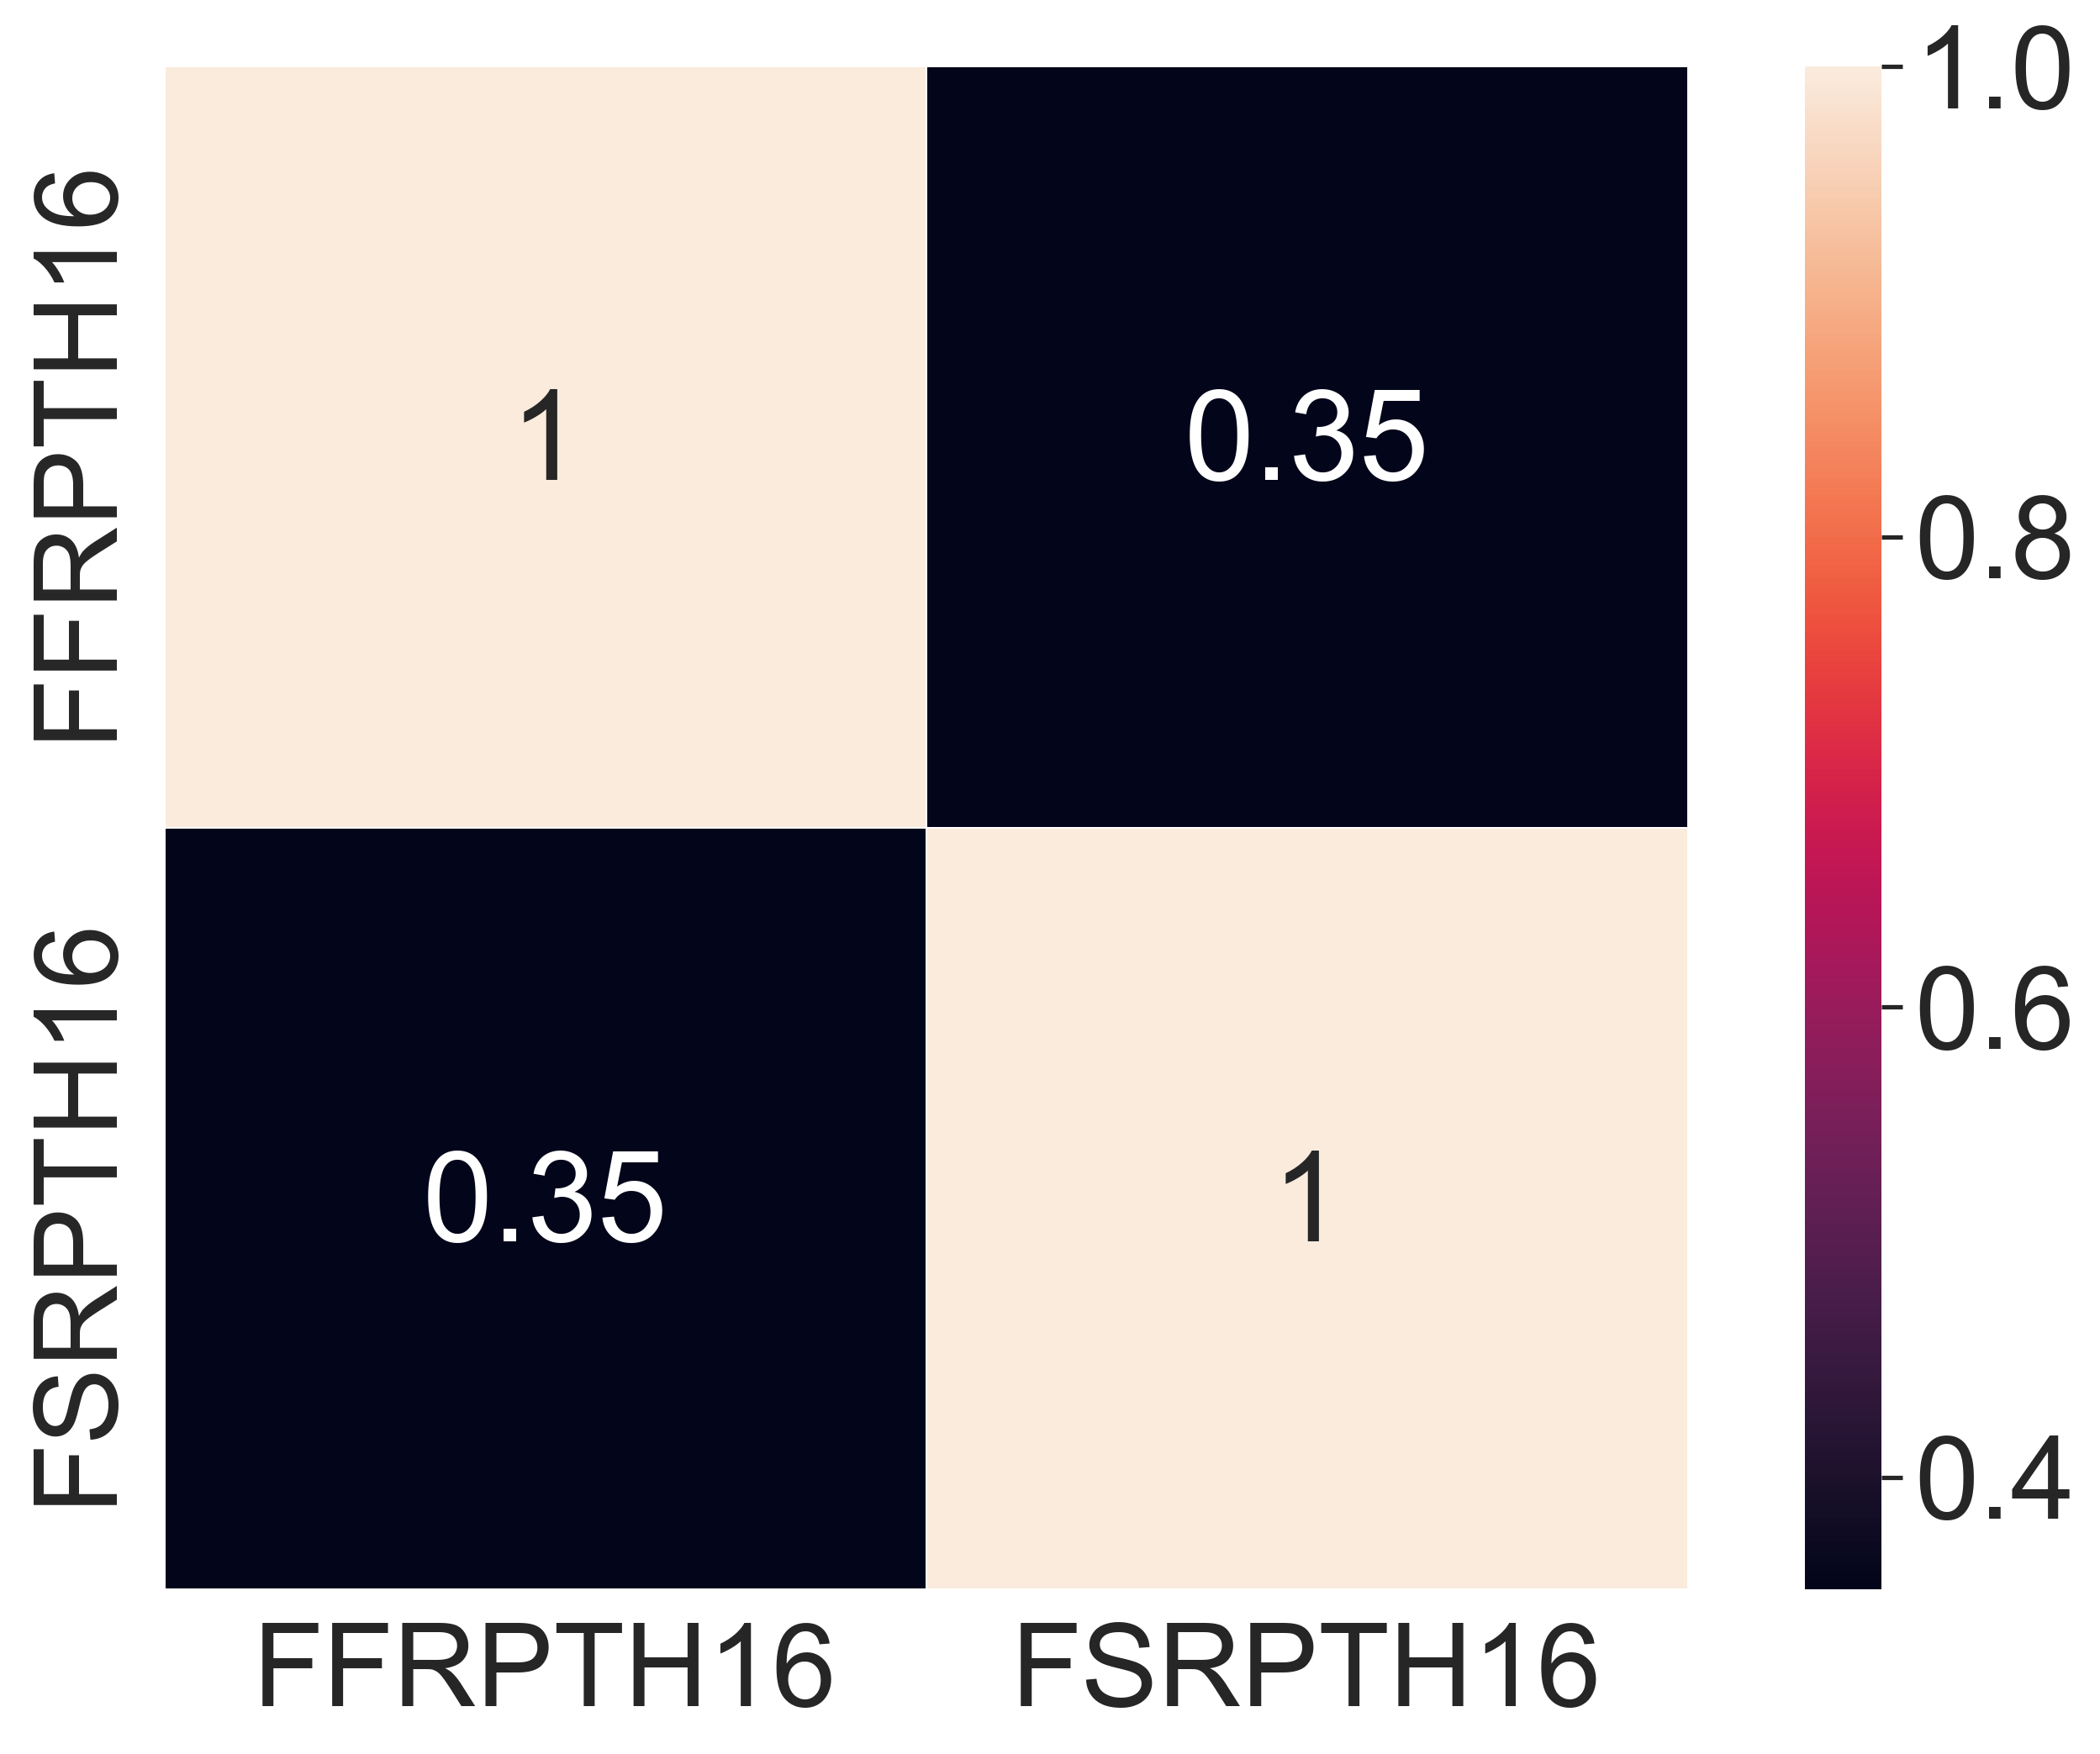

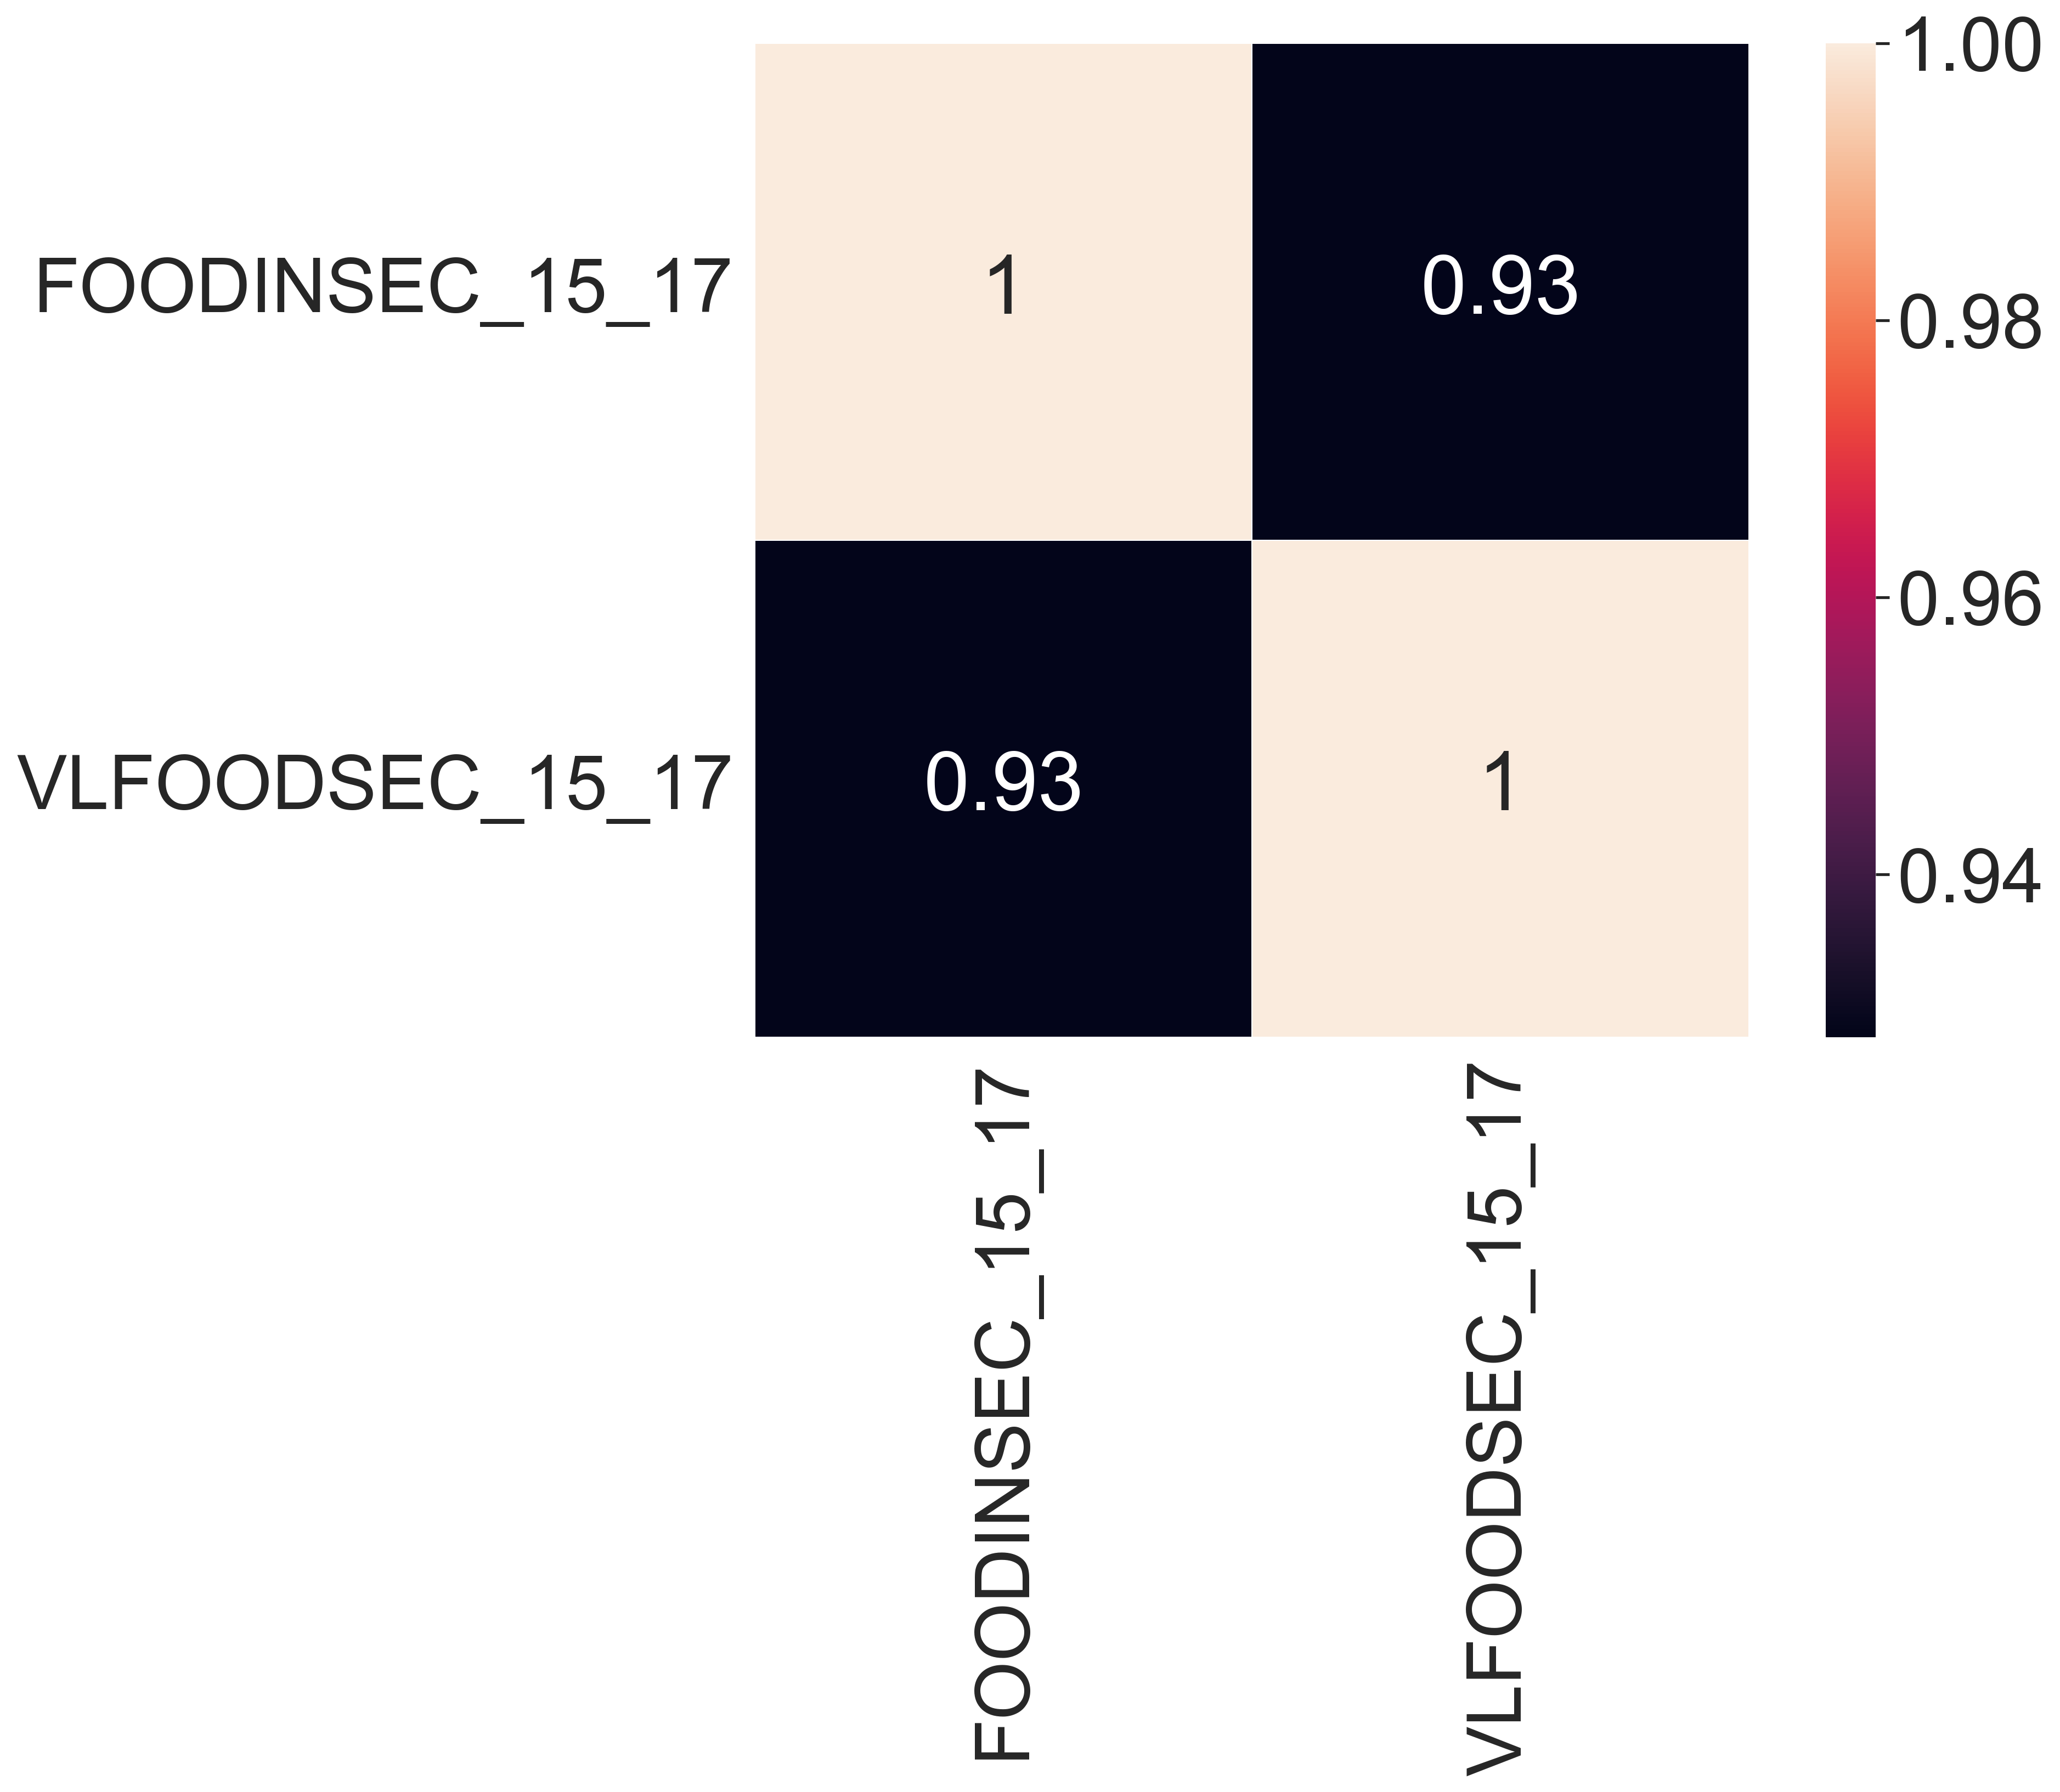

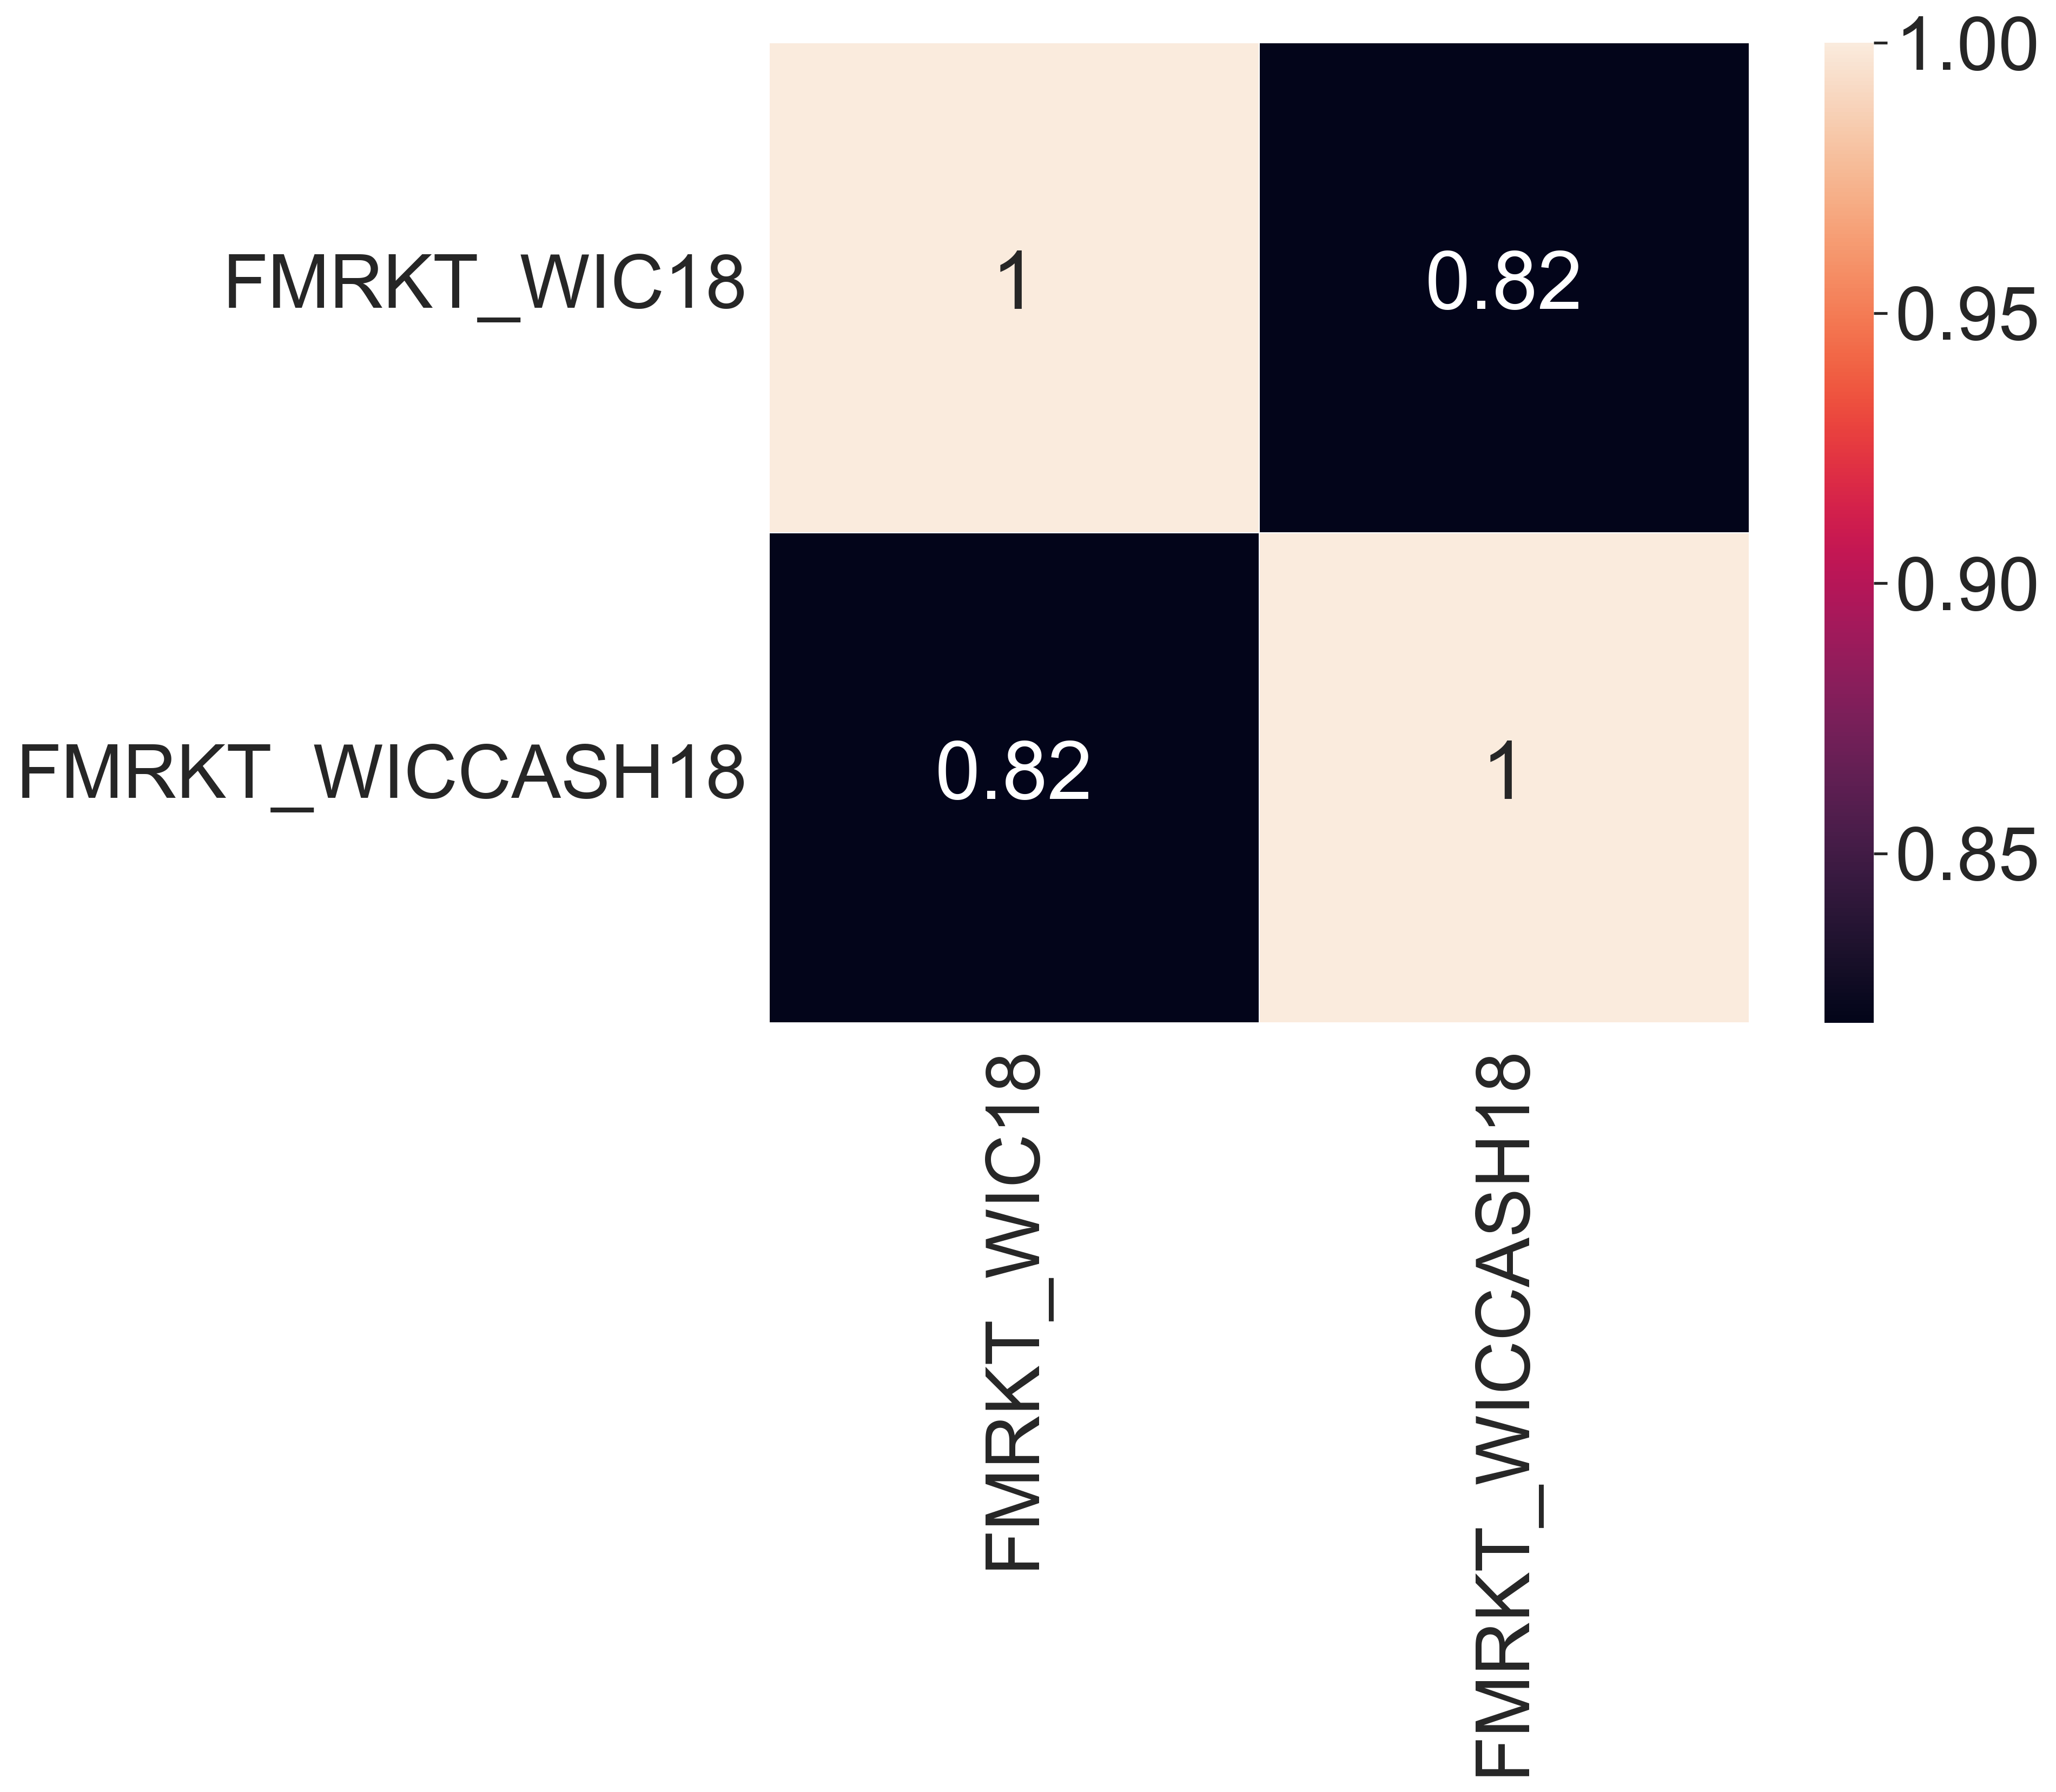

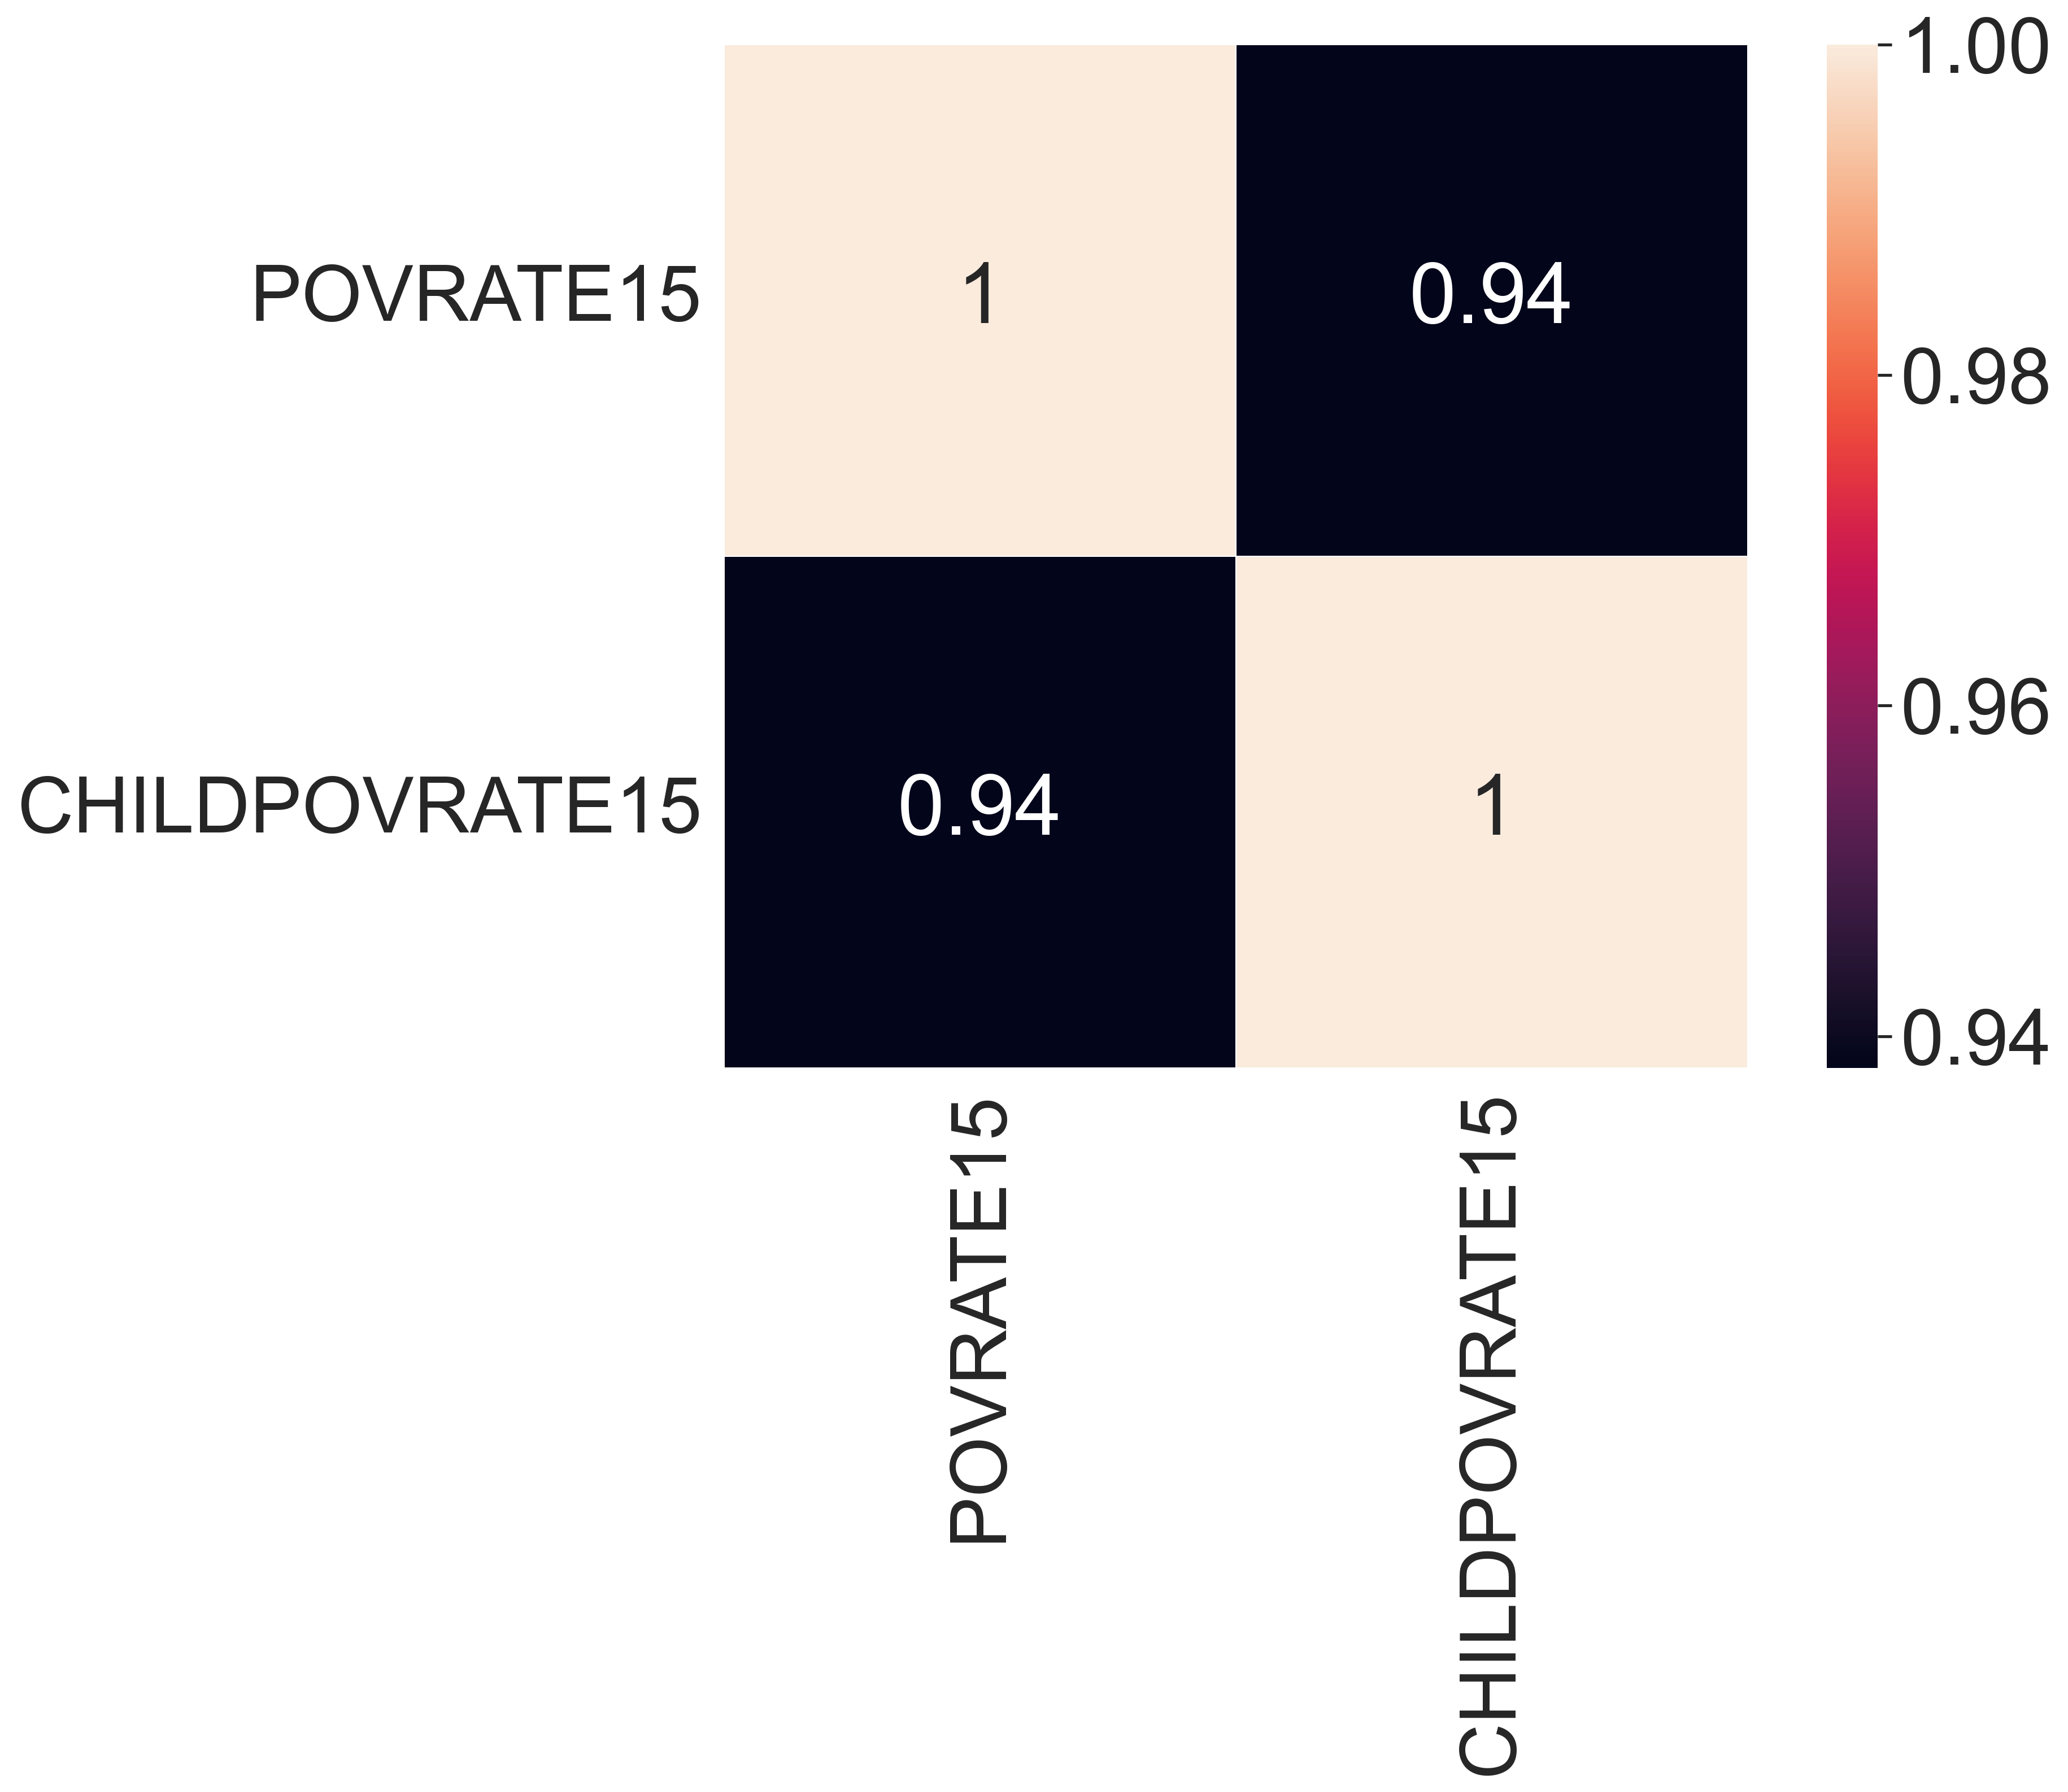

In [47]:
for i in range(len(group)):
    corr = raw_data[group[i]].corr()
    plt.figure(figsize = (12,8), dpi = 300)
    sns.set(font_scale=3)
    sns.heatmap(corr,linewidths=0.1,vmax=1.0, square=True,linecolor='white', annot=True)
    plt.savefig('corr_heatmap_{}.jpg'.format(i))

## Data preprocessing

In [6]:
preserve_columns = ['County','State','Population_Estimate_2016','LACCESS_POP15','GROCPTH16',
                    'SUPERCPTH16','CONVSPTH16','SPECSPTH16','WICSPTH16','FFRPTH16','FSRPTH16',
                    'FOODINSEC_15_17','FMRKT_WIC18','POVRATE15','PCT_WIC17']
raw_data = raw_data[preserve_columns]
raw_data['PCT_WIC17'] = raw_data['PCT_WIC17'] * raw_data['Population_Estimate_2016']
raw_data['FOODINSEC_15_17'] = raw_data['FOODINSEC_15_17'] * raw_data['Population_Estimate_2016']
raw_data['POVRATE15'] = raw_data['POVRATE15'] * raw_data['Population_Estimate_2016']

# for i in range(raw_data.shape[1]-2):
#     plt.figure(figsize = (12,8), dpi = 300)
#     plt.plot(range(raw_data.shape[0]), raw_data.iloc[:,i+2])
#     print(preserve_columns[i+2])



In [7]:
enc = TargetEncoder(cols = ['State']).fit(raw_data['State'],raw_data['PCT_WIC17'])
raw_data['State'] = enc.transform(raw_data['State'])

D:\Program\anaconda\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
D:\Program\anaconda\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [8]:
data = raw_data.sample(frac = 1, random_state=913).values
X_train = np.float64(data[:2512,1:-1])
y_train = np.float64(data[:2512,-1])
X_test = np.float64(data[2512:,1:-1])
y_test = np.float64(data[2512:,-1])

## Ridge

In [9]:
# 由于和lasso以及ElasticNet差不多，因此在此暂不考虑

# Ridge_clfs = []
# ridge_accuracy = []
# ridge_accuracy_std = []

# for i in range(5):
#     clf = KernelRidge(alpha = 10 ** (i - 2), kernel = 'linear')
#     Ridge_clfs.append(clf)

# means1, stds1 = cross_validate(Ridge_clfs)
# plot_errbar([0.01, 0.1, 1, 10, 100], means1, stds1)

In [10]:
# Ridge_clfs = []
# for i in range(5):
#     clf = KernelRidge(alpha = 10 ** (i - 2), kernel = 'sigmoid')
#     Ridge_clfs.append(clf)
# means2, stds2 = cross_validate(Ridge_clfs)
# plot_errbar([0.01, 0.1, 1, 10, 100], means2, stds2)

In [11]:
# Ridge_clfs = []
# for i in range(5):
#     clf = KernelRidge(alpha = 10 ** (i - 2), kernel = 'rbf')
#     Ridge_clfs.append(clf)
# means3, stds3 = cross_validate(Ridge_clfs)
# plot_errbar([0.01, 0.1, 1, 10, 100], means3, stds3)

## Lasso

In [12]:
# 由于和Ridge以及ElasticNet差不多，因此在此暂不考虑

# Lasso_clfs = []
# for i in range(5):
#     clf = Lasso(alpha = 10 ** (i - 2), max_iter = 5000, random_state = 913)
#     Lasso_clfs.append(clf)
# means_lasso, stds_lasso = cross_validate(Lasso_clfs)
# plot_errbar([0.01, 0.1, 1, 10, 100], means_lasso, stds_lasso)

## Elastic Net

In [13]:
# ElasticNet_clfs = []
# l1_ratio = [0.25,0.5,0.75]
# for i in range(3):
#     same_ratio = []
#     for j in range(5):
#         clf = ElasticNet(alpha = 10 ** (i - 2), l1_ratio = l1_ratio[i], random_state = 913, max_iter = 5000)
#         same_ratio.append(clf)
#     ElasticNet_clfs.append(clf)
    
#     mean_ela, std_ela = cross_validate(same_ratio)
#     plot_errbar([0.01, 0.1, 1, 10, 100], mean_ela, std_ela)
    
# mean_ela, std_ela = cross_validate(ElasticNet_clfs)

In [14]:
encv = ElasticNetCV(alphas=(0.1, 0.01, 0.005, 0.001), l1_ratio=(0.25, 0.5, 0.75, 0.9), normalize=True)
encv.fit(X_train, y_train)
print('ElasticNet optimal alpha: %.3f and L1 ratio: %.4f' % (encv.alpha_, encv.l1_ratio_))

ElasticNet optimal alpha: 0.001 and L1 ratio: 0.9000


D:\Program\anaconda\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(


In [18]:
tmp_model = ElasticNet(alpha=0.001, l1_ratio=0.9, random_state=1212, max_iter=5000).fit(X_train, y_train)
print(cross_validate([tmp_model]))

([0.9659267178607136], [0.01602936413156204], 0)


D:\Program\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.644e+11, tolerance: 1.734e+11
  model = cd_fast.enet_coordinate_descent(
D:\Program\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.957e+11, tolerance: 9.012e+10
  model = cd_fast.enet_coordinate_descent(
D:\Program\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.285e+12, tolerance: 1.648e+11
  

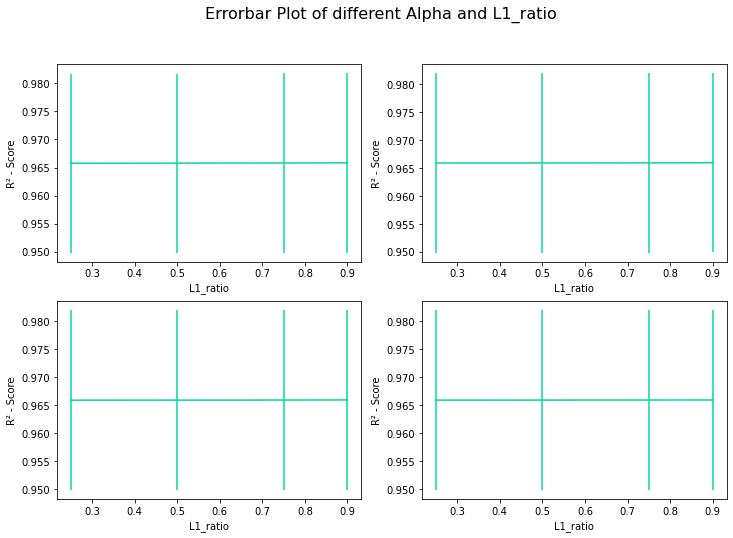

score 0.9659267178607136
alpha 0.001
ratio 0.9


In [37]:
alphas = [0.1, 0.01, 0.005, 0.001]
l1_ratio = [0.25, 0.5, 0.75, 0.9]

best_score = 0
best_alpha = 0
best_ratio = 0

fig = plt.figure(figsize=(12, 8))

for i, alpha in enumerate(alphas):
    mean_list = []
    std_list = []
    ElasticNet_clfs = []

    for radio in l1_ratio:
        model = ElasticNet(alpha=alpha, l1_ratio=radio, random_state=1212, max_iter=5000).fit(X_train, y_train)
        ElasticNet_clfs.append(model)

    mean_tmp, std_tmp, best_index = cross_validate(ElasticNet_clfs)
    
    if best_score < mean_tmp[best_index]:
        best_score = mean_tmp[best_index]
        best_ratio = l1_ratio[best_index]
        best_alpha = alpha
    
    ax = fig.add_subplot(2, 2, i + 1)
    ax.errorbar(l1_ratio, mean_tmp, yerr=std_tmp, c='#06d6a0', label="alhpa = {}".format(alpha))
    plt.xlabel('L1_ratio')
    plt.ylabel('R² - Score')

fig.suptitle("Errorbar Plot of different Alpha and L1_ratio", fontsize=16)
plt.show()

print('score', best_score)
print('alpha', best_alpha)
print('ratio', best_ratio)


In [23]:
clf = LinearRegression()
clf = clf.fit(X_train[:2000], y_train[:2000])
clf.score(X_test, y_test)

0.8850040085872408

## Decision tree

[[0.9219024240176521, 0.9219024240176521, 0.9219024240176521], [0.9278172354931096, 0.9278172354931096, 0.9278172354931096], [0.929487152554348, 0.929487152554348, 0.929487152554348], [0.9210507623092571, 0.9210507623092571, 0.9210507623092571]]
[]


ValueError: too many values to unpack (expected 1)

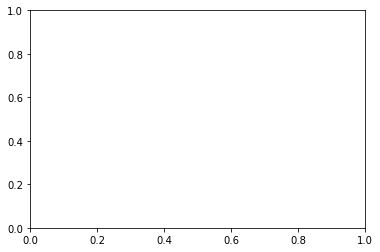

In [38]:
DecisionTrees = []
criterion_list = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']

for cri in criterion_list:
    clf = DecisionTreeRegressor(criterion=cri, random_state = 913)
    DecisionTrees.append(clf)
    score = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'r2')
means_ = []
stds_ = []
    # get the best alpha and score
#     curr_score = score.mean()
#     print("----???:", curr_score, score)
#     if curr_score > best_score:
#         best_score = curr_score
#         best_index = index

# means = []
# stds = []
# for i in DecisionTrees:
#     score = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'r2')
#     means.append(score.mean())
#     stds.append(score.std(ddof = 1))

# means_dt, stds_dt, best_index = cross_validate(DecisionTrees)

# print(means_dt)

print(means)
print(stds)
plt.errorbar(l1_ratio, means, yerr=stds, c='#06d6a0')

# print('best_score', means_dt[best_index])

## NN

In [26]:
%%time
NNs = []
size_list = [(64,8),(64,16,4),(128,16),(128,32,8)]
for i in range(len(size_list)):
    NN_same_size = []
    for j in range(3):
        clf = MLPRegressor(hidden_layer_sizes = size_list[i], learning_rate_init = 10 ** (-i - 2),
                           random_state = 913, max_iter = 2000)
        clf.fit(X_train, y_train)
        NN_same_size.append(clf)
        
#         plt.plot(clf.loss_curve_)
#         plt.title("Loss Curve", fontsize=14)
#         plt.xlabel('Iterations')
#         plt.ylabel('Cost')
#         plt.show()
    NNs.append(NN_same_size)

means = []
stds = []
for i in range(len(NNs)):
    mean, std, index = cross_validate(NNs[i])
    means.append(mean)
    std.append(std)

print(means)

[[0.9219024240176521, 0.9219024240176521, 0.9219024240176521], [0.9278172354931096, 0.9278172354931096, 0.9278172354931096], [0.929487152554348, 0.929487152554348, 0.929487152554348], [0.9210507623092571, 0.9210507623092571, 0.9210507623092571]]
CPU times: total: 3min 14s
Wall time: 1min 43s
